# Facial Recognition: The Big Blunder
Gabriel Kao | Seyma Oz | Tiffany Tran
## Dataset:
https://www.kaggle.com/andrewmvd/face-mask-detection

### Imports!

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/.kaggle/docker-python
# For example, here's several helpful packages to load

#import all modules
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import random as rn

import tensorflow as tf
import cv2
import glob
from tqdm import tqdm
import xml.etree.ElementTree as ET

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as k
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Dropout,Activation
from tensorflow.keras.layers import Conv2D,BatchNormalization,MaxPooling2D
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

from tensorflow.keras.layers import LeakyReLU

from tensorflow.keras import metrics




### We pulled the dataset off Kaggle, so the filepath is virtually the same.

In [2]:
import os
Dirname = []
Filenames =[]
for dirname, _, filenames in os.walk('./kaggle/input'):
    for filename in filenames:
        Dirname.append(dirname)
        Filenames.append(filename)
        X = os.path.join(dirname, filename)
#print(Filenames)        
        
Dir = './kaggle/input/face-mask-detection'
print(os.listdir(Dir))
images_path = os.path.join(Dir,'images')
print("Image path = {}".format(images_path))
print("Total number of images : {}".format(len(os.listdir(images_path))))
Annotation_path = './kaggle/input/face-mask-detection/annotations'
print("Annotation path = {}".format(Annotation_path))
print("Total Annotation files are {}".format(len(os.listdir(Annotation_path))))

Image_width = 80
Image_height = 80
Image_array = []
Labels = []

#Check label files are according to images files
Sorted_files = sorted(os.listdir(Annotation_path))
#print(Sorted_files)
Sorted_images_path = sorted(os.listdir(images_path))
#print(Sorted_images_path)


['annotations', 'images']
Image path = ./kaggle/input/face-mask-detection\images
Total number of images : 853
Annotation path = ./kaggle/input/face-mask-detection/annotations
Total Annotation files are 853


### Function definition for getting the bounding boxes and then runs image pre-processing from the dataset.

In [3]:
# Prepare data and respective labels
def get_box(obj):
    
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]


for file in tqdm(sorted(os.listdir(Annotation_path)),desc='Preparing data..'):
    file_path = Annotation_path + "/" + file
    xml = ET.parse(file_path)
    root = xml.getroot()
    image_path = images_path + "/" + root[1].text

     
    for bndbox in root.iter('bndbox'):
        [xmin, ymin, xmax, ymax] = get_box(bndbox)
        #Read in image into img
        img = cv2.imread(image_path)
        #Crop image by bounding box
        face_img = img[ymin:ymax,xmin:xmax]
        #Resize image to 80, 80
        face_img  = cv2.resize(face_img,(Image_width,Image_height))
        #Append list with np.array(image)
        Image_array.append(np.array(face_img)) 
    
    for obj in root.findall('object'):
        name = obj.find('name').text 
        Labels.append(np.array(name)) 


Preparing data..: 100%|██████████| 853/853 [00:28<00:00, 30.13it/s]


### Normalization, set the number of classes.

In [4]:
#Normalize the data
num_classes = 3
#Make np.array out of list
X = np.array(Image_array)
X = X/255

le = LabelEncoder()
y = le.fit_transform(Labels)
y  = to_categorical(y,num_classes)

###  Print a subsect of 16 random images to double check input validity.

(4072, 80, 80, 3)
(4072, 3)


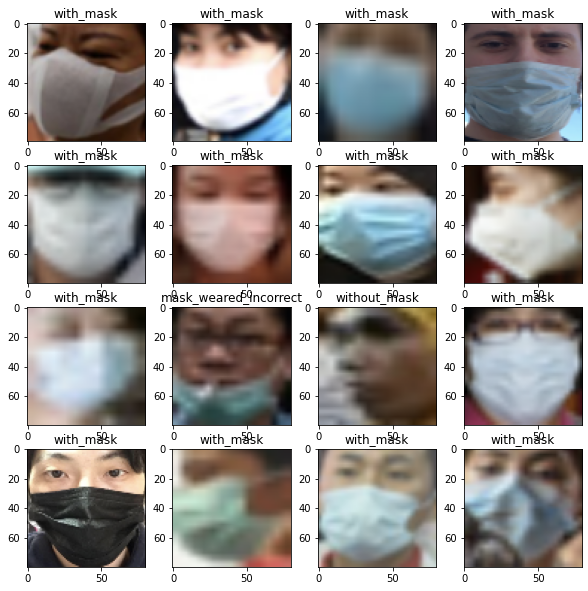

In [5]:
#Check the total Images and label length are equal 
print(X.shape)
print(y.shape)

#Check random images 
fig,ax = plt.subplots(4,4)
fig.set_size_inches(10,10)

for i in range(4):
    for j in range(4):
        l = rn.randint(0,len(Labels))
        
        image = cv2.cvtColor(Image_array[l], cv2.COLOR_BGR2RGB)

        ax[i,j].imshow(image)
        ax[i,j].set_title(Labels[l])


### Split the dataset!

In [6]:
        
#Split the data for training and validation        
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size = 0.20,random_state = 42)
#Check the total training images
print(X_train.shape)
print(y_train.shape)  

(3257, 80, 80, 3)
(3257, 3)


### Model design!

In [7]:
# design model
model = Sequential()

model.add(Conv2D(32,(3,3),padding='SAME',activation='relu',input_shape=(Image_width,Image_height,3)))  #first layer to extract features from an input image. 
model.add(MaxPooling2D(pool_size=(2,2)))  #reduce the num of parameters
model.add(Dropout(0.5))

# 2. convlolutional layer
model.add(Conv2D(64,(3,3),padding='SAME',activation='relu'))    # we want to increase feature extraction
model.add(MaxPooling2D(pool_size=(2,2)))  #reduce the num of parameters
model.add(Dropout(0.5))

model.add(Flatten())

#dense layer
model.add(Dense(90,activation='relu')) # 256 amount of nodes
model.add(Dropout(0.5))
model.add(LeakyReLU(alpha=0.05))

model.add(Dense(3,activation = "softmax"))

model.summary()


Batch_size = 64
Epochs = 20
seed = 1000

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 80, 80, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 40, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 20, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 25600)             0

### We use Keras' ImageDataGenerator to skew the data even further, and set the EarlyStop properties.

In [8]:
#Augmented Images
train_datagen = ImageDataGenerator(
                    rotation_range = 10,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    fill_mode = 'nearest')
#Callbacks
Estop = EarlyStopping(monitor = 'val_loss',patience = 2,verbose = 1,min_delta = 0.01)


### The meat and potatoes. Model training!

In [9]:
#Compile the model
model.compile(optimizer = Adam(lr = 0.001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy', 
                         metrics.Precision(), 
                         metrics.Recall(),
                        ])
model.summary()
history = model.fit(train_datagen.flow(X_train, y_train, batch_size = Batch_size),
                    steps_per_epoch = X_train.shape[0]//Batch_size,
                    epochs = Epochs,
                    validation_data = (X_val,y_val),
                    verbose=1 ,
                    callbacks=[Estop],
                    ) 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 80, 80, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 40, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 20, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 25600)             0

C:\Users\gabek\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/20
50/50 [==============================] - 6s 70ms/step - loss: 0.7648 - accuracy: 0.7670 - precision: 0.7973 - recall: 0.7416 - val_loss: 0.7048 - val_accuracy: 0.8945 - val_precision: 0.9799 - val_recall: 0.4196
Epoch 2/20
50/50 [==============================] - 3s 61ms/step - loss: 0.3581 - accuracy: 0.8913 - precision: 0.9054 - recall: 0.8606 - val_loss: 0.2870 - val_accuracy: 0.9227 - val_precision: 0.9434 - val_recall: 0.8798
Epoch 3/20
50/50 [==============================] - 3s 61ms/step - loss: 0.2977 - accuracy: 0.9154 - precision: 0.9250 - recall: 0.8995 - val_loss: 0.2463 - val_accuracy: 0.9264 - val_precision: 0.9395 - val_recall: 0.9153
Epoch 4/20
50/50 [==============================] - 3s 57ms/step - loss: 0.2995 - accuracy: 0.9164 - precision: 0.9261 - recall: 0.8988 - val_loss: 0.2512 - val_accuracy: 0.9313 - val_precision: 0.9385 - val_recall: 0.9178
Epoch 5/20
50/50 [==============================] - 3s 57ms/step - loss: 0.2872 - accuracy: 0.9151 - precisi

### Just following the crucial steps still. Accuracy and loss plots.

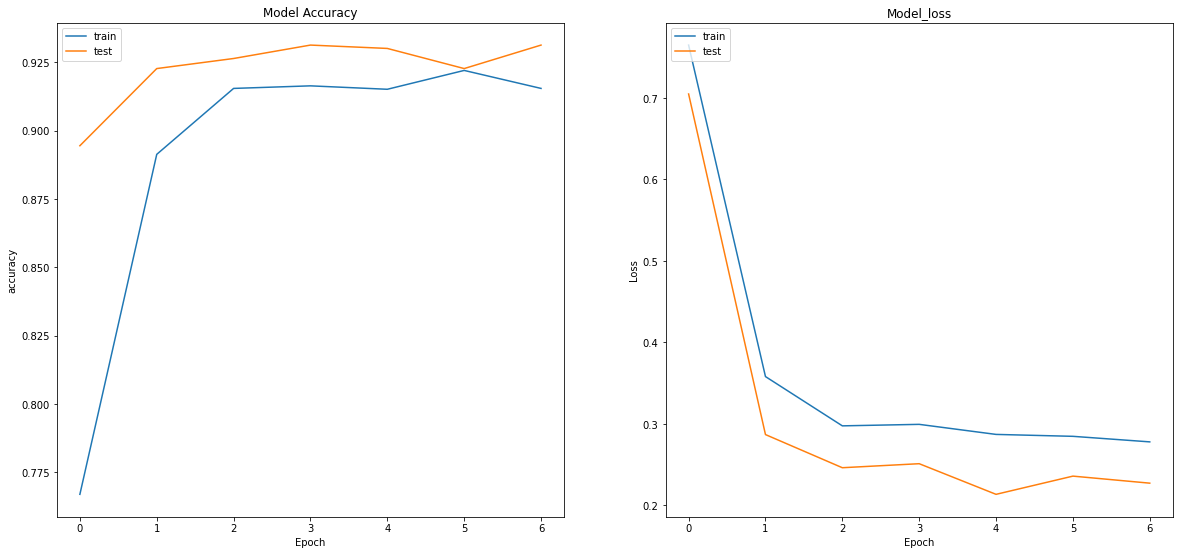

In [10]:
#plot the history
def plot_model_performance(history):
    fig =plt.figure(figsize = (20,20))
    #plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train','test'],loc ="upper left")
    #plt.show()
    
    #plt.figure()
    #plot loss 
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model_loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train','test'],loc ="upper left")
    plt.show()


    
plot_model_performance(history)

### Make Prediction on Random Sample from Dataset

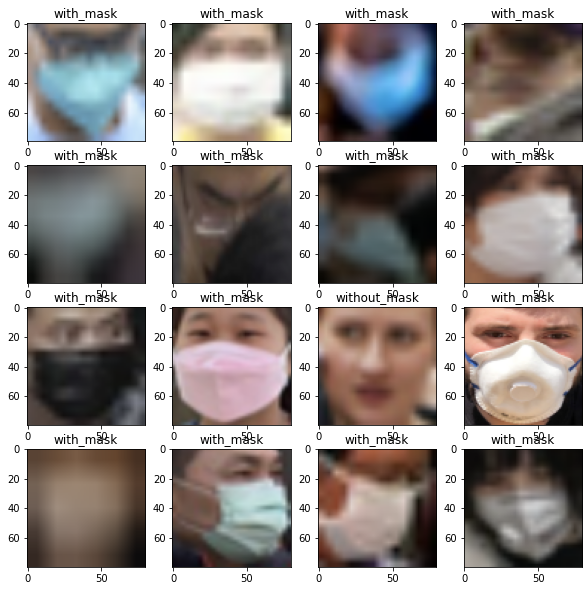

In [20]:
mask_classes = ['mask_weared_incorrect','with_mask','without_mask']

fig,ax = plt.subplots(4,4)
fig.set_size_inches(10,10)

for i in range(4):
    for j in range(4):
        l = rn.randint(0,len(Labels))
        
        image = cv2.cvtColor(Image_array[l], cv2.COLOR_BGR2RGB)
        temp = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        temp = temp.reshape(-1, 80, 80, 3)
        pred_random = np.argmax(model.predict(temp), axis=-1)

        ax[i,j].imshow(image)
        ax[i,j].set_title(mask_classes[pred_random[0]])


# Facial Detection and Prediction
### Had issue with saving the previous classification model in TF2.5, even as H5, so I just gave up and did it sequentially within the notebook for what is probably the borkiest implementation I could think of.

In [12]:
# I like the imports for sections separate, so.
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from scipy.spatial import distance

### Loading and testing the Haar Cascade on a random image pulled from Google.

319 90 495 495
pred: [[0.09162934 0.26223356 0.6461371 ]]
pred3: no mask detected


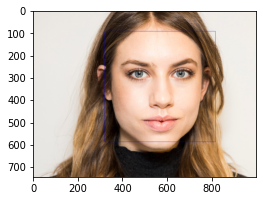

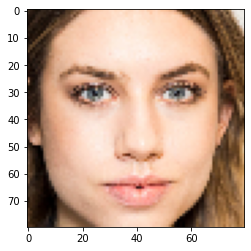

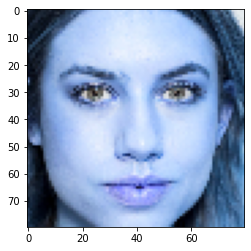

In [13]:
# Load Haar Cascade
face_model = cv2.CascadeClassifier('./haarcascades/haarcascade_frontalface_alt2.xml')

# Load image
img = cv2.imread('./dataset/face.png')

# Grayscale of img
gray = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

# Bounding box grabby grabby
faces = face_model.detectMultiScale(gray,
                                    scaleFactor=1.1, 
                                    minNeighbors=5, 
                                    minSize=(60,60),
                                    flags=cv2.CASCADE_SCALE_IMAGE)

# Get a BGR version of img
out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) 

# Get bounding box coords
for (x,y,w,h) in faces:
    cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,0,255),1)
plt.figure(figsize=(4,4))
plt.imshow(out_img)

# Use the bounds to crop the input image and display
print(x, y, w, h)
crop_img = out_img[y:y+h, x:x+w]
crop_img = cv2.resize(crop_img,(80, 80))
plt.figure(figsize=(4,4))
plt.imshow(crop_img)

# This was mainly for me, just wanted to see the BGR conversion.
plt.figure(figsize=(4,4))
crop_img = cv2.cvtColor(crop_img, cv2.COLOR_RGB2BGR)
plt.imshow(crop_img)

# And then get the prediction off the bounding box too. Settings the stage
# for converting this to the next part.
labels = ['incorrect', 'mask detected', 'no mask detected']
crop_img = crop_img.reshape(-1, 80, 80, 3)
crop_img = crop_img/255
pred = model.predict(crop_img)
pred3 = np.argmax(model.predict(crop_img), axis=-1)
print('pred:', pred)
print('pred3:', labels[pred3[0]])


### I suppose this is Main!

In [14]:
labels = ['incorrect', 'no mask detected', 'mask detected']
cap = cv2.VideoCapture(0)

while(True):
    ret, frame = cap.read()

    # So I'm not even sure I need to normalize the histogram. Originally
    # when I was having issues with prediction I thought it might help,
    # with detection, but I think that's just the tradeoff of using a 
    # pre-trained model. Also not very glasses friendly!
    gray = cv2.cvtColor(frame, cv2.IMREAD_GRAYSCALE)
    hist,bins = np.histogram(img.flatten(), 256, [0,256])
    faces = face_model.detectMultiScale(gray,
                                        scaleFactor=1.1, 
                                        minNeighbors=5, 
                                        minSize=(60,60),
                                        flags=cv2.CASCADE_SCALE_IMAGE)
    out_img = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR) 

    # So it only displays the bounding box if the Haar Cascade can even find
    # a face. I probably should've done it so it just repeats the last bounding
    # box if it doesn't but this seemed more 'accurate'.
    if (len(faces) > 0):
        (x, y, w, h) = faces[0]
        crop_img = out_img[y:y+h, x:x+w]
        crop_img = cv2.resize(crop_img,(80, 80))
        crop_img = crop_img.reshape(-1, 80, 80, 3)
        crop_img = crop_img/255

        # Pretty straightforward, like all the other examples I've seen. Grab the
        # frame, process it, predict on it, print its result on the bounding box.
        pred = np.argmax(model.predict(crop_img), axis=-1)
        color = (0,255,0)
        cv2.putText(frame, labels[int(pred)], (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
    
    # Deesplay
    cv2.imshow('frame', frame)

    # Quit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break


# Bye bye, capture.
cap.release()
cv2.destroyAllWindows()

### Manual precision calculations just to verify the Keras version, and also to get macro/micro. 

In [15]:
mask_classes = ['mask_weared_incorrect','with_mask','without_mask']

y_true = []
y_pred = []
for x in range(len(Labels)):
    y_true.append(mask_classes.index(Labels[x]))
    reshaped_img = Image_array[x].reshape(-1, 80, 80, 3)
    y_pred.append(np.argmax(model.predict(reshaped_img), axis=-1)[0])

print('precision')
print("micro:", precision_score(y_true, y_pred, average='micro', zero_division=1))
print("macro:", precision_score(y_true, y_pred, average='macro', zero_division=1))
print("weighted:", precision_score(y_true, y_pred, average='weighted', zero_division=1))



precision
micro: 0.931237721021611
macro: 0.9272538131546447
weighted: 0.9360834381695047


### Calculate time in m/s per 100 predictions

In [24]:
import time
y_pred=[]
tot_time = 0
# So I only repeatedly re-predict one image. I didn't think it mattered much because our times were
# many factors slower than other papers anyway. At this point it's a mercy-finish.
l = rn.randint(0,len(Labels))
image = cv2.cvtColor(Image_array[l], cv2.COLOR_BGR2RGB)
img_reshape = image.reshape(-1, 80, 80, 3)
for x in range(100):
    start = time.time()
    y_pred.append(np.argmax(model.predict(img_reshape), axis=-1)[0])
    end = time.time()
    tot_time = tot_time + (end-start)

print("Time (in m/s, per 100 preds):",tot_time*1000)

AttributeError: module 'time' has no attribute 'clock'

### And then lastly, once I realized we made a big oopsie, I needed to check the proportions of our dataset. This is all that that is. 

In [17]:
mask_classes = ['mask_weared_incorrect','with_mask','without_mask']

y_true = []
# for x in range(len(Labels)):
for x in range(10):
    y_true.append(mask_classes.index(Labels[x]))

print('length of labels', len(Labels))
print('incorrect', Labels.count('mask_weared_incorrect'))
print('with', Labels.count('with_mask'))
print('without', Labels.count('without_mask'))

length of labels 4072
incorrect 123
with 3232
without 717
